In [1]:
# Dependencies
import numpy as np
import datetime as dt# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session,Query
from sqlalchemy import create_engine, func
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [3]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [4]:
#Columns for each Table Since this module expects us to just go in blindly following...
meas_columns = session.execute('select * from Measurement').keys()
stat_columns = session.execute('select * from Station').keys()
print(f"Measurement Columns:\n{list(meas_columns)}")
print()
print(f"Station Columns:\n{list(stat_columns)}")

Measurement Columns:
['id', 'station', 'date', 'prcp', 'tobs']

Station Columns:
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


## D1: Determine the Summary Statistics for June

In [5]:
session.query(Measurement.date).all()[-5:]

[('2017-08-19',),
 ('2017-08-20',),
 ('2017-08-21',),
 ('2017-08-22',),
 ('2017-08-23',)]

In [6]:
# 1. Import the sqlalchemy extract function.
from sqlalchemy import extract

# 2. Write a query that filters the Measurement table to retrieve the temperatures for the month of June.

june_temps = session.query(Measurement.tobs).\
            filter(extract('month', Measurement.date)==6).all()
len(june_temps)


1700

In [7]:
#  3. Convert the June temperatures to a list.
june_temps = list(np.ravel(june_temps))
june_temps[:10]

[78.0, 76.0, 78.0, 76.0, 77.0, 78.0, 77.0, 78.0, 78.0, 79.0]

In [8]:
# 4. Create a DataFrame from the list of temperatures for the month of June. 
june_temp_df = pd.DataFrame(june_temps, columns=['June Temps'])
june_temp_df

,June Temps
0,78.0
1,76.0
2,78.0
3,76.0
4,77.0
...,...
1695,79.0
1696,74.0
1697,74.0
1698,76.0


In [9]:
# 5. Calculate and print out the summary statistics for the June temperature DataFrame.
june_temp_df.describe()

,June Temps
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


## D2: Determine the Summary Statistics for December

In [10]:
# 6. Write a query that filters the Measurement table to retrieve the temperatures for the month of December.
results = session.query(Measurement.tobs).\
        filter(extract('month', Measurement.date)=='12').all()
results[:10]

[(76.0,),
 (74.0,),
 (74.0,),
 (64.0,),
 (64.0,),
 (67.0,),
 (77.0,),
 (66.0,),
 (69.0,),
 (68.0,)]

In [11]:
# 7. Convert the December temperatures to a list.
dec_temps = list(np.ravel(results))
dec_temps[:10]

[76.0, 74.0, 74.0, 64.0, 64.0, 67.0, 77.0, 66.0, 69.0, 68.0]

In [12]:
# 8. Create a DataFrame from the list of temperatures for the month of December. 
dec_temps_df = pd.DataFrame(dec_temps, columns=['Dec. Temps'])
dec_temps_df

,Dec. Temps
0,76.0
1,74.0
2,74.0
3,64.0
4,64.0
...,...
1512,71.0
1513,71.0
1514,69.0
1515,65.0


In [13]:
# 9. Calculate and print out the summary statistics for the December temperature DataFrame.
dec_temps_df.describe()

,Dec. Temps
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


# Extra Queries

## 1. Average Precipitation of all months per station

In [14]:
session.execute('SELECT * FROM Measurement').keys()

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])

In [15]:
months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']

def avg_per_station(column_to_avg):
    month_avgs = {'Station':sorted(session.query(Measurement.station).distinct().all())}
    for i,j in enumerate(months):
        i += 1
        month_avgs[j] = session.query(func.avg(column_to_avg)).\
                                        group_by(Measurement.station).filter(extract('month', Measurement.date)==i).all()
    
    avgs = pd.DataFrame(month_avgs)
    avgs['Station'] = avgs['Station'].apply(lambda x: str(x).replace('(','')).apply(lambda x: str(x).replace(',)','')).apply(lambda x: x.replace("'",""))
    for i in months:
        avgs[i] = avgs[i].apply(lambda x: str(x).replace('(','')).apply(lambda x: str(x).replace(',)',''))
        avgs[i] = pd.to_numeric(avgs[i])
        
    return avgs

In [16]:
avg_precip = avg_per_station(Measurement.prcp)
avg_precip

,Station,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,USC00511918,0.070391,0.043836,0.079817,0.032840,0.041617,0.015157,0.021761,0.023774,0.025385,0.053392,0.028425,0.138146
1,USC00513117,0.116327,0.159686,0.210645,0.099958,0.126016,0.118248,0.139955,0.123066,0.127135,0.140741,0.136619,0.203241
2,USC00514830,0.096312,0.146692,0.120375,0.085450,0.105482,0.114192,0.142880,0.105347,0.099437,0.146034,0.139085,0.154966
3,USC00516128,0.239828,0.233941,0.405882,0.463379,0.369543,0.495748,0.526791,0.443960,0.531667,0.448352,0.532193,0.507005
4,USC00517948,0.046275,0.093860,0.190541,0.035167,0.067500,0.057975,0.030000,0.047846,0.027286,0.022593,0.040714,0.152727
5,USC00518838,0.290392,0.069500,0.406071,0.373636,0.195366,0.094615,0.209474,0.071379,0.018800,0.121923,0.184615,0.638182
6,USC00519281,0.179073,0.172301,0.272621,0.188542,0.234516,0.151525,0.207621,0.221903,0.222714,0.221898,0.234545,0.244931
7,USC00519397,0.040086,0.067361,0.089013,0.034786,0.040208,0.022661,0.048368,0.027922,0.047192,0.039577,0.060640,0.075314
8,USC00519523,0.123864,0.143732,0.170749,0.116818,0.085738,0.050044,0.088423,0.099643,0.110000,0.101759,0.134794,0.162010


In [17]:
stations_pivot = {'Month':months}
for i in [j for j in avg_precip['Station']]:
    stations_pivot[i] = []
    for j in months:
        stations_pivot[i].append(avg_precip[j][avg_precip['Station']==i].item())

In [18]:
stations_precip = pd.DataFrame(stations_pivot)
stations_precip = stations_precip.reset_index(drop=True)
stations_precip

,Month,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
0,Jan,0.070391,0.116327,0.096312,0.239828,0.046275,0.290392,0.179073,0.040086,0.123864
1,Feb,0.043836,0.159686,0.146692,0.233941,0.093860,0.069500,0.172301,0.067361,0.143732
2,Mar,0.079817,0.210645,0.120375,0.405882,0.190541,0.406071,0.272621,0.089013,0.170749
3,Apr,0.032840,0.099958,0.085450,0.463379,0.035167,0.373636,0.188542,0.034786,0.116818
4,May,0.041617,0.126016,0.105482,0.369543,0.067500,0.195366,0.234516,0.040208,0.085738
5,June,0.015157,0.118248,0.114192,0.495748,0.057975,0.094615,0.151525,0.022661,0.050044
6,July,0.021761,0.139955,0.142880,0.526791,0.030000,0.209474,0.207621,0.048368,0.088423
7,Aug,0.023774,0.123066,0.105347,0.443960,0.047846,0.071379,0.221903,0.027922,0.099643
8,Sep,0.025385,0.127135,0.099437,0.531667,0.027286,0.018800,0.222714,0.047192,0.110000
9,Oct,0.053392,0.140741,0.146034,0.448352,0.022593,0.121923,0.221898,0.039577,0.101759


## 2. Combining Station Information With Avg. Precip

In [19]:
session.execute('SELECT * FROM Station').keys()

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])

In [20]:
station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_info

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [21]:
stations_df = pd.DataFrame(station_info, columns=['Station','Name','Lat','Lon','Elev'])
stations_df

,Station,Name,Lat,Lon,Elev
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Since we are looking to open a surf shop, we are only interested in weather data by sea-level, filtering out high elevation stations.

In [22]:
precip_avgs_df = stations_df.merge(avg_precip, how='left', on='Station')
surf_shop_stations = precip_avgs_df[precip_avgs_df['Elev']<100]
surf_shop_stations

,Station,Name,Lat,Lon,Elev,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.040086,0.067361,0.089013,0.034786,0.040208,0.022661,0.048368,0.027922,0.047192,0.039577,0.060640,0.075314
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.116327,0.159686,0.210645,0.099958,0.126016,0.118248,0.139955,0.123066,0.127135,0.140741,0.136619,0.203241
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.096312,0.146692,0.120375,0.085450,0.105482,0.114192,0.142880,0.105347,0.099437,0.146034,0.139085,0.154966
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.046275,0.093860,0.190541,0.035167,0.067500,0.057975,0.030000,0.047846,0.027286,0.022593,0.040714,0.152727
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.123864,0.143732,0.170749,0.116818,0.085738,0.050044,0.088423,0.099643,0.110000,0.101759,0.134794,0.162010
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.179073,0.172301,0.272621,0.188542,0.234516,0.151525,0.207621,0.221903,0.222714,0.221898,0.234545,0.244931
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.070391,0.043836,0.079817,0.032840,0.041617,0.015157,0.021761,0.023774,0.025385,0.053392,0.028425,0.138146


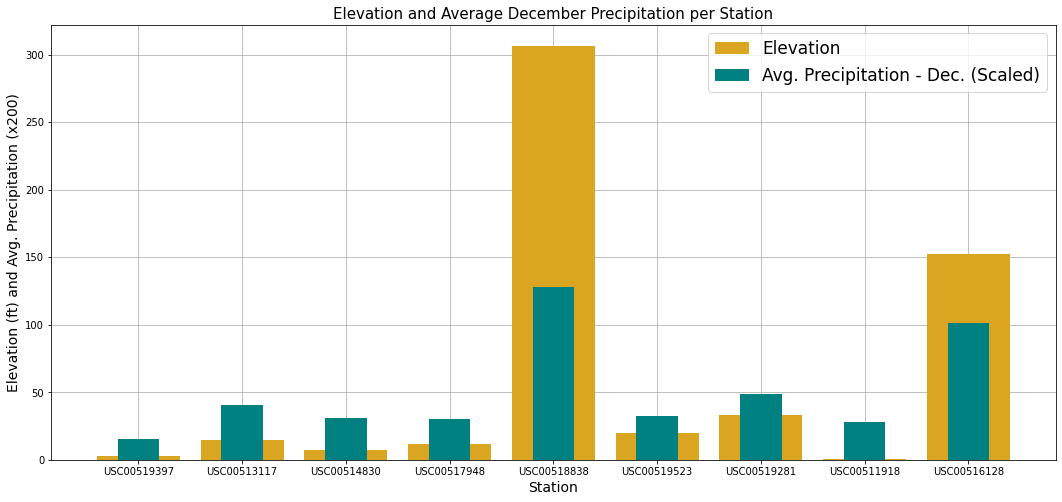

In [23]:
plt.figure(figsize=(18,8))

plt.bar(precip_avgs_df['Station'], precip_avgs_df['Elev'], zorder=3, color='goldenrod', label='Elevation')
plt.bar(precip_avgs_df['Station'], precip_avgs_df['Dec']*200, zorder=3, color='teal', width=0.4, label='Avg. Precipitation - Dec. (Scaled)')

plt.title('Elevation and Average December Precipitation per Station', fontsize=15)
plt.xlabel('Station', fontsize=14)
plt.ylabel('Elevation (ft) and Avg. Precipitation (x200)', fontsize=14)
plt.legend(fontsize=17)
plt.grid(zorder=6.5)
plt.show()

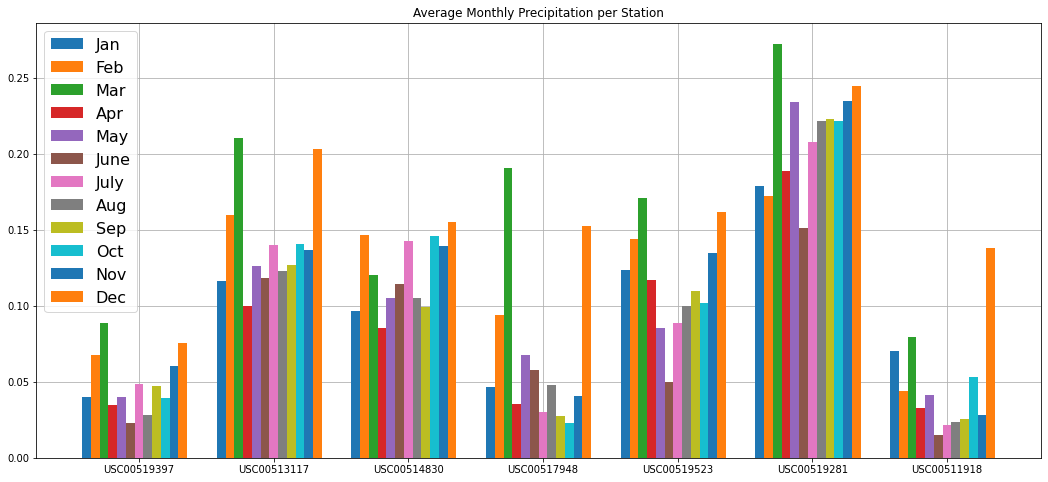

In [24]:
plt.figure(figsize=(18,8))
x_vals = [i for i in surf_shop_stations['Station']]
x_tix = np.arange(len(x_vals))

width = 0.065*6


for i,j in enumerate(months):
    if i < 6:
        plt.bar([k-width for k in range(len(x_vals))], surf_shop_stations[j], width=0.065, label=j, zorder=3.5)
        width -= 0.065
    else:
        if i==6:
            width = 0.0
        plt.bar([k+width for k in range(len(x_vals))], surf_shop_stations[j], width=0.065, label=j, zorder=3.5)
        width += 0.065
        
plt.xticks(np.arange(0,7, step=1), x_vals)

plt.legend(loc='upper left', fontsize=16)
plt.title('Average Monthly Precipitation per Station')
plt.grid(zorder=6.5)

plt.show()


In [28]:
two_prime_locs = session.execute(
    'SELECT * FROM Station WHERE Station.station == "USC00519397"' 
    'OR Station.station == "USC00511918"'
    'OR Station.station == "USC00517948"')

In [29]:
two_prime_locs.all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)]

In [30]:
surf_shop_stations.loc[(surf_shop_stations['Station']=='USC00519397') | 
                       (surf_shop_stations['Station']=='USC00511918') |
                      (surf_shop_stations['Station']=='USC00517948')]

,Station,Name,Lat,Lon,Elev,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.040086,0.067361,0.089013,0.034786,0.040208,0.022661,0.048368,0.027922,0.047192,0.039577,0.060640,0.075314
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.046275,0.093860,0.190541,0.035167,0.067500,0.057975,0.030000,0.047846,0.027286,0.022593,0.040714,0.152727
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,0.070391,0.043836,0.079817,0.032840,0.041617,0.015157,0.021761,0.023774,0.025385,0.053392,0.028425,0.138146
